In [1]:
# Run this cell FIRST, before importing comorbidipy
import pandas as pd
from pandas.errors import SettingWithCopyWarning

# Patch the old location so comorbidipy can find it
pd.core.common.SettingWithCopyWarning = SettingWithCopyWarning

# Now you can import comorbidipy
from comorbidipy import comorbidity, hfrs, disability

In [2]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [3]:
zip_path = r"C:\Users\maxim\Downloads\mimic-iii-clinical-database-1.4.zip"

In [4]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('mimic-iii-clinical-database-1.4/DIAGNOSES_ICD.csv.gz') as gz_file:
        diagnoses = pd.read_csv(gz_file, compression='gzip')

In [12]:
diagnoses.head(15)

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254
5,1302,109,172335,6.0,2762
6,1303,109,172335,7.0,7100
7,1304,109,172335,8.0,2767
8,1305,109,172335,9.0,7243
9,1306,109,172335,10.0,45829


In [6]:
diagnoses.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE'], dtype='object')

In [99]:
df = pd.read_csv('hr_rr_t_ag_dbp_sbp_age_gender_mortality.csv')
df.head(3)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,SYSBP_STD,SYSBP_MIN,SYSBP_MAX,SYSBP_COUNT,DIASBP_MEAN,DIASBP_MEDIAN,DIASBP_STD,DIASBP_MIN,DIASBP_MAX,DIASBP_COUNT
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,27.048903,15.0,162.0,98.0,52.326531,52.0,10.997446,12.0,86.0,98.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,9.154864,83.0,126.0,65.0,51.538462,51.0,8.739417,32.0,78.0,65.0
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,17.451830,71.0,163.0,79.0,48.594937,49.0,7.365058,33.0,71.0,79.0


In [100]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'MORTALITY_INHOSPITAL',
       'HR_MEAN', 'HR_MEDIAN', 'HR_STD', 'HR_MIN', 'HR_MAX', 'HR_COUNT',
       'RR_MEAN', 'RR_MEDIAN', 'RR_STD', 'RR_MIN', 'RR_MAX', 'RR_COUNT',
       'TEMP_MEAN', 'TEMP_MEDIAN', 'TEMP_STD', 'TEMP_MIN', 'TEMP_MAX',
       'TEMP_COUNT', 'AGE', 'GENDER', 'GENDER_BINARY', 'AG_MEAN', 'AG_MEDIAN',
       'AG_STD', 'AG_MIN', 'AG_MAX', 'AG_COUNT', 'SYSBP_MEAN', 'SYSBP_MEDIAN',
       'SYSBP_STD', 'SYSBP_MIN', 'SYSBP_MAX', 'SYSBP_COUNT', 'DIASBP_MEAN',
       'DIASBP_MEDIAN', 'DIASBP_STD', 'DIASBP_MIN', 'DIASBP_MAX',
       'DIASBP_COUNT'],
      dtype='object')

### Elixhauser score

In [101]:
hadm_ids = df['HADM_ID'].unique()

In [102]:
# Step 1: Extract only necessary columns from df (HADM_ID and AGE)
age_data = df[['HADM_ID', 'AGE']].copy()

# Step 2: Merge age with diagnoses
# Use left merge to keep all diagnosis records
diagnoses_with_age = diagnoses.merge(
    age_data,
    on='HADM_ID',
    how='left'
)

diagnoses_with_age = diagnoses_with_age[diagnoses_with_age['HADM_ID'].isin(hadm_ids)]

In [103]:
# Sanity Check
diagnoses_with_age['HADM_ID'].nunique() == df['HADM_ID'].nunique()

True

In [104]:
# Step 3: Workaround for library bug - rename columns to default names
diagnoses_renamed = diagnoses_with_age.rename(columns={
    'HADM_ID': 'id',
    'ICD9_CODE': 'code',
    'AGE': 'age'
})

# Step 4: Calculate Elixhauser score with age
elixhauser_scores_with_age = comorbidity(
    diagnoses_renamed,
    id='id',                # Use default 'id' name
    code='code',            # Use default 'code' name
    age='age',              # Use default 'age' name
    score='elixhauser',     # Calculate Elixhauser score
    icd='icd9',             # MIMIC-III uses ICD-9 codes
    variant='quan',   
    weighting='vw',         # van Walraven weighting
    assign0=True
)

In [105]:
elixhauser_scores_with_age = elixhauser_scores_with_age.rename(columns={
    'id': 'HADM_ID'
})

In [106]:
elixhauser_scores_with_age.head()

,HADM_ID,age,aids,alcohol,blane,carit,chf,coag,cpd,dane,...,psycho,pud,pvd,rf,rheumd,solidtum,valv,wloss,comorbidity_score,age_adj_comorbidity_score
0,172335,24.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,20.0,20.0
1,114585,75.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,18.0,21.0
2,164853,49.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,23.0,23.0
3,112906,71.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,8.0
4,138376,75.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,26.0,29.0


#### Sanity check: The function adds a new column age. Does this column display the true values?

In [107]:
# Get a list of all valid HADM_IDs in our dataframe
hadm_ids = df['HADM_ID'].unique()

In [108]:
# Keep only the valid HADM_IDs
x = elixhauser_scores_with_age[elixhauser_scores_with_age['HADM_ID'].isin(hadm_ids)]

x.head(6)

,HADM_ID,age,aids,alcohol,blane,carit,chf,coag,cpd,dane,...,psycho,pud,pvd,rf,rheumd,solidtum,valv,wloss,comorbidity_score,age_adj_comorbidity_score
0,172335,24.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,20.0,20.0
1,114585,75.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,18.0,21.0
2,164853,49.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,23.0,23.0
3,112906,71.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,8.0
4,138376,75.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,26.0,29.0
5,141647,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,12.0


In [109]:
# Merge the dataframes on HADM_ID
merged = df.merge(x, on='HADM_ID', suffixes=('_df', '_x'))

# Check if any values differ
differs = (merged['AGE'] != merged['age']).any()

if differs:
    print("AGE and age columns differ!")
    # Show rows where they differ
    diff_rows = merged[merged['AGE'] != merged['age']]
    print(f"Number of differing rows: {len(diff_rows)}")
    print(diff_rows)
else:
    print("AGE and age columns are identical")

AGE and age columns are identical


#### Do cormobidity_score and age_adj_cormobidity_score differ?

In [110]:
# First, let's see basic statistics
print("=== Basic Statistics ===")
print("\ncomorbidity_score:")
print(x['comorbidity_score'].describe())
print("\nage_adj_comorbidity_score:")
print(x['age_adj_comorbidity_score'].describe())

=== Basic Statistics ===

comorbidity_score:
count    21247.000000
mean        10.982068
std          8.284212
min          0.000000
25%          5.000000
50%         10.000000
75%         17.000000
max         54.000000
Name: comorbidity_score, dtype: float64

age_adj_comorbidity_score:
count    21247.000000
mean        13.078317
std          8.701239
min          0.000000
25%          6.000000
50%         13.000000
75%         19.000000
max         58.000000
Name: age_adj_comorbidity_score, dtype: float64


In [112]:
import pandas as pd
import numpy as np

# First, let's see basic statistics
print("=== Basic Statistics ===")
print("\ncomorbidity_score:")
print(x['comorbidity_score'].describe())
print("\nage_adj_comorbidity_score:")
print(x['age_adj_comorbidity_score'].describe())

# Check if they differ at all
print("\n=== Do they differ? ===")
are_identical = x['comorbidity_score'].equals(x['age_adj_comorbidity_score'])
print(f"Columns are identical: {are_identical}")

if not are_identical:
    # Calculate the difference
    x['difference'] = x['age_adj_comorbidity_score'] - x['comorbidity_score']
    
    print("\n=== Difference Statistics ===")
    print(x['difference'].describe())
    
    # How many are different?
    num_different = (x['comorbidity_score'] != x['age_adj_comorbidity_score']).sum()
    print(f"\nNumber of rows where values differ: {num_different} out of {len(x)}")
    
    # Show some examples of differences
    print("\n=== Sample of differing values ===")
    diff_rows = x[x['difference'] != 0].head(10)
    print(diff_rows[['HADM_ID', 'comorbidity_score', 'age_adj_comorbidity_score', 'difference', 'age']])
    
    # Analyze the pattern of differences
    print("\n=== Pattern Analysis ===")
    
    # Is it a constant adjustment?
    print(f"Mean difference: {x['difference'].mean():.4f}")
    print(f"Median difference: {x['difference'].median():.4f}")
    print(f"Std of difference: {x['difference'].std():.4f}")
    
    # Is the difference related to the original score?
    print("\n=== Ratio Analysis ===")
    x['ratio'] = x['age_adj_comorbidity_score'] / x['comorbidity_score'].replace(0, np.nan)
    print(f"Mean ratio: {x['ratio'].mean():.4f}")
    print(f"Median ratio: {x['ratio'].median():.4f}")
    
    # Is the difference related to age?
    print("\n=== Age Relationship ===")
    correlation = x['difference'].corr(x['age'])
    print(f"Correlation between difference and age: {correlation:.4f}")
    
    # Group by age ranges to see pattern
    x['age_group'] = pd.cut(x['age'], bins=[0, 30, 50, 70, 90, 120], 
                            labels=['0-30', '30-50', '50-70', '70-90', '90+'])
    age_analysis = x.groupby('age_group').agg({
        'comorbidity_score': 'mean',
        'age_adj_comorbidity_score': 'mean',
        'difference': 'mean'
    })
    print("\nMean values by age group:")
    print(age_analysis)

=== Basic Statistics ===

comorbidity_score:
count    21247.000000
mean        10.982068
std          8.284212
min          0.000000
25%          5.000000
50%         10.000000
75%         17.000000
max         54.000000
Name: comorbidity_score, dtype: float64

age_adj_comorbidity_score:
count    21247.000000
mean        13.078317
std          8.701239
min          0.000000
25%          6.000000
50%         13.000000
75%         19.000000
max         58.000000
Name: age_adj_comorbidity_score, dtype: float64

=== Do they differ? ===
Columns are identical: False

=== Difference Statistics ===
count    21247.000000
mean         2.096249
std          1.414216
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: difference, dtype: float64

Number of rows where values differ: 17171 out of 21247

=== Sample of differing values ===
    HADM_ID  comorbidity_score  age_adj_comorbidity_score  difference   age
1    114585              

Conclusion: age_adj_comorbidity_score penelizes the age of patients and increases the Elixhauser score. This means that age_adj_comorbidity_score is alwys >= comorbidity_score. It also implies that a person of age 25 has a lower score than a person of age 75, assuming both persons have the same diagnoses.

#### Correlation Analysis

In [113]:
# Select only the columns we need to merge
scores_to_merge = elixhauser_scores_with_age[['HADM_ID', 'comorbidity_score']].copy()

# Check if age_adj_comorbidity_score exists
if 'age_adj_comorbidity_score' in elixhauser_scores_with_age.columns:
    scores_to_merge['age_adj_comorbidity_score'] = elixhauser_scores_with_age['age_adj_comorbidity_score']

# Merge to df
df = df.merge(
    scores_to_merge,
    on='HADM_ID',
    how='left'
)


In [114]:
df.head(5)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,SYSBP_MAX,SYSBP_COUNT,DIASBP_MEAN,DIASBP_MEDIAN,DIASBP_STD,DIASBP_MIN,DIASBP_MAX,DIASBP_COUNT,comorbidity_score,age_adj_comorbidity_score
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,162.0,98.0,52.326531,52.0,10.997446,12.0,86.0,98.0,20.0,22.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,126.0,65.0,51.538462,51.0,8.739417,32.0,78.0,65.0,4.0,4.0
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,163.0,79.0,48.594937,49.0,7.365058,33.0,71.0,79.0,15.0,19.0
3,274,130546,254851,0,92.716981,93.0,11.774120,63.0,116.0,53.0,...,197.0,241.0,69.780083,70.0,8.684599,44.0,109.0,241.0,0.0,2.0
4,275,129886,219649,1,59.933333,59.0,8.632391,49.0,90.0,45.0,...,180.0,193.0,79.331606,80.0,11.112769,50.0,102.0,193.0,9.0,13.0


In [115]:
print("\nCorrelation with In-Hospital Mortality:")

if 'MORTALITY_INHOSPITAL' in df.columns:
    # Calculate correlations
    correlation_comorbidity = df['comorbidity_score'].corr(df['MORTALITY_INHOSPITAL'])
    print(f"Comorbidity Score vs Mortality: {correlation_comorbidity:.4f}")
    
    if 'age_adj_comorbidity_score' in df.columns:
        correlation_age_adj = df['age_adj_comorbidity_score'].corr(df['MORTALITY_INHOSPITAL'])
        print(f"Age-Adjusted Comorbidity Score vs Mortality: {correlation_age_adj:.4f}")


Correlation with In-Hospital Mortality:
Comorbidity Score vs Mortality: 0.2078
Age-Adjusted Comorbidity Score vs Mortality: 0.2163



=== Mortality Rates by Comorbidity Score ===
                   Mortality_Rate  N_Admissions
comorbidity_score                              
0.0                      0.058805          3129
1.0                      0.021834           229
2.0                      0.035874           446
3.0                      0.053712           633
4.0                      0.054010           611
5.0                      0.091612          1681
6.0                      0.075676           740
7.0                      0.112660           861
8.0                      0.085414           761
9.0                      0.115987           638


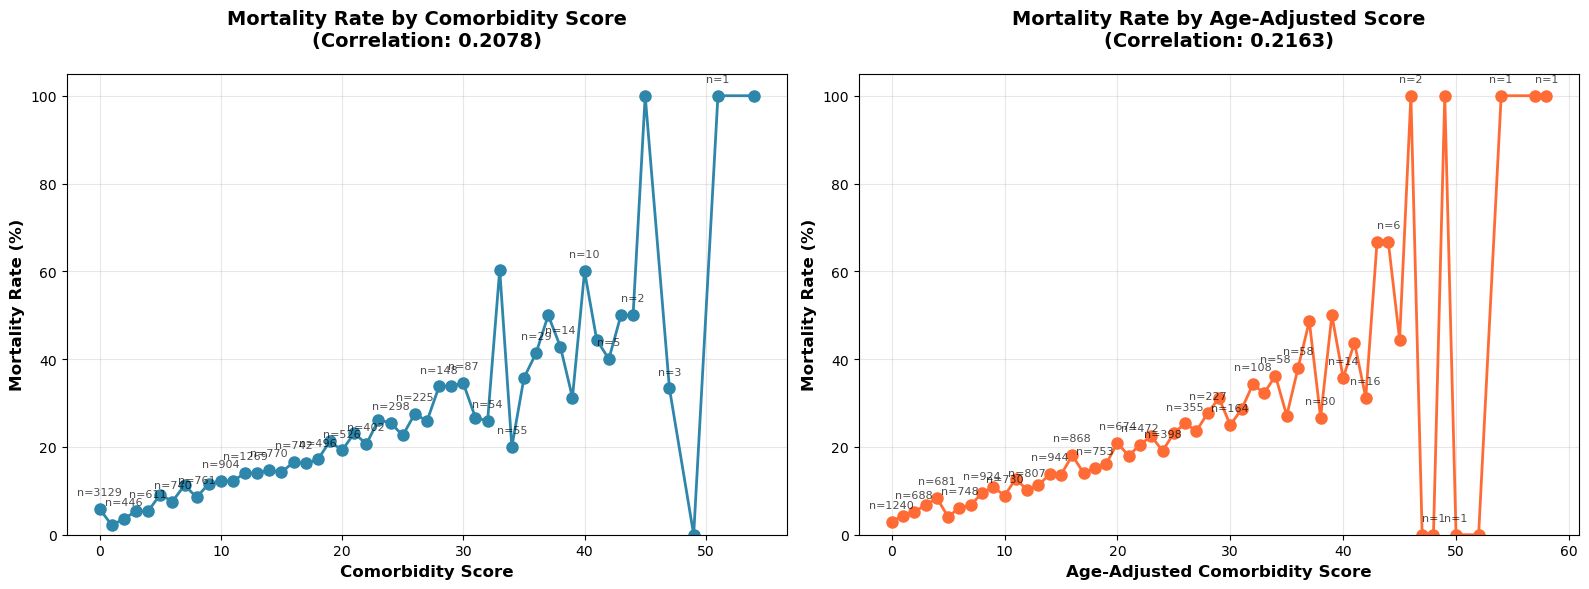


=== Summary Statistics ===
Basic Score - Mean Mortality: 13.17%
Basic Score - Score Range: 0 to 54
Adj Score - Score Range: 0 to 58


In [116]:
if 'MORTALITY_INHOSPITAL' in df.columns:
    
    # Calculate mortality rates by score
    print("\n=== Mortality Rates by Comorbidity Score ===")
    mortality_by_score = df.groupby('comorbidity_score')['MORTALITY_INHOSPITAL'].agg(['mean', 'count'])
    mortality_by_score.columns = ['Mortality_Rate', 'N_Admissions']
    print(mortality_by_score.head(10))
    
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Basic Comorbidity Score
    mortality_basic = df.groupby('comorbidity_score').agg({
        'MORTALITY_INHOSPITAL': ['mean', 'count']
    }).reset_index()
    mortality_basic.columns = ['score', 'mortality_rate', 'count']
    
    axes[0].plot(mortality_basic['score'], mortality_basic['mortality_rate'] * 100, 
                 marker='o', linewidth=2, markersize=8, color='#2E86AB')
    axes[0].set_xlabel('Comorbidity Score', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Mortality Rate (%)', fontsize=12, fontweight='bold')
    axes[0].set_title(f'Mortality Rate by Comorbidity Score\n(Correlation: {correlation_comorbidity:.4f})', 
                     fontsize=14, fontweight='bold', pad=20)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(bottom=0)
    
    # Add sample size annotations
    for idx, row in mortality_basic.iterrows():
        if idx % 2 == 0:  # Annotate every other point to avoid crowding
            axes[0].annotate(f'n={int(row["count"])}', 
                           xy=(row['score'], row['mortality_rate'] * 100),
                           xytext=(0, 10), textcoords='offset points',
                           fontsize=8, ha='center', alpha=0.7)
    
    # Plot 2: Age-Adjusted Comorbidity Score
    if 'age_adj_comorbidity_score' in df.columns:
        mortality_adj = df.groupby('age_adj_comorbidity_score').agg({
            'MORTALITY_INHOSPITAL': ['mean', 'count']
        }).reset_index()
        mortality_adj.columns = ['score', 'mortality_rate', 'count']
        
        axes[1].plot(mortality_adj['score'], mortality_adj['mortality_rate'] * 100, 
                     marker='o', linewidth=2, markersize=8, color='#FF6B35')
        axes[1].set_xlabel('Age-Adjusted Comorbidity Score', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Mortality Rate (%)', fontsize=12, fontweight='bold')
        axes[1].set_title(f'Mortality Rate by Age-Adjusted Score\n(Correlation: {correlation_age_adj:.4f})', 
                         fontsize=14, fontweight='bold', pad=20)
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim(bottom=0)
        
        # Add sample size annotations
        for idx, row in mortality_adj.iterrows():
            if idx % 2 == 0:
                axes[1].annotate(f'n={int(row["count"])}', 
                               xy=(row['score'], row['mortality_rate'] * 100),
                               xytext=(0, 10), textcoords='offset points',
                               fontsize=8, ha='center', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison summary
    print("\n=== Summary Statistics ===")
    print(f"Basic Score - Mean Mortality: {df['MORTALITY_INHOSPITAL'].mean()*100:.2f}%")
    print(f"Basic Score - Score Range: {df['comorbidity_score'].min():.0f} to {df['comorbidity_score'].max():.0f}")
    if 'age_adj_comorbidity_score' in df.columns:
        print(f"Adj Score - Score Range: {df['age_adj_comorbidity_score'].min():.0f} to {df['age_adj_comorbidity_score'].max():.0f}")
    
else:
    print("Warning: 'MORTALITY_INHOSPITAL' column not found in df")
    print(f"Available columns: {df.columns.tolist()}")

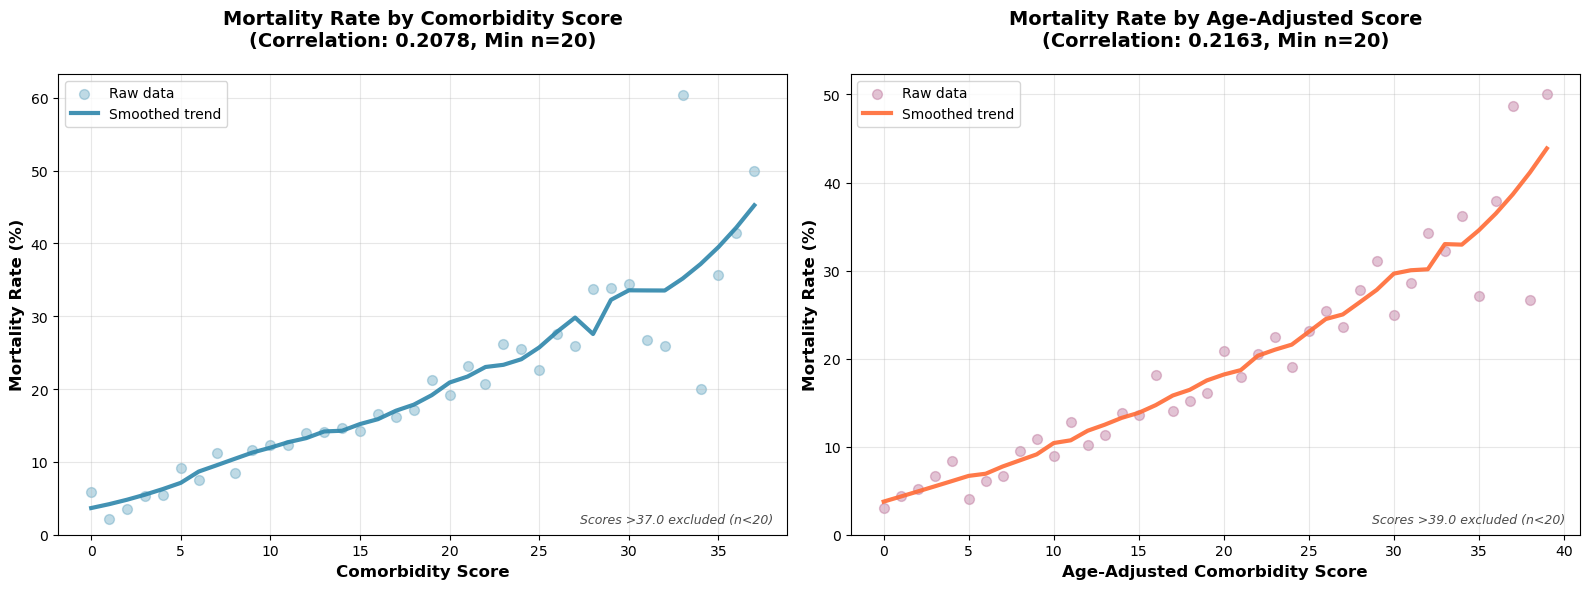

In [117]:
from scipy.signal import savgol_filter

if 'MORTALITY_INHOSPITAL' in df.columns:
    
    # Set minimum sample size threshold
    MIN_SAMPLES = 20  # Only show scores with at least 20 admissions
    SMOOTHING_WINDOW = 11  # Window size for smoothing (must be odd, larger = smoother)
    
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Basic Comorbidity Score
    mortality_basic = df.groupby('comorbidity_score').agg({
        'MORTALITY_INHOSPITAL': ['mean', 'count']
    }).reset_index()
    mortality_basic.columns = ['score', 'mortality_rate', 'count']
    
    # Filter by minimum sample size
    mortality_basic_filtered = mortality_basic[mortality_basic['count'] >= MIN_SAMPLES].copy()
    
    # Plot raw data points with low opacity
    axes[0].scatter(mortality_basic_filtered['score'], 
                   mortality_basic_filtered['mortality_rate'] * 100,
                   alpha=0.3, s=50, color='#2E86AB', label='Raw data')
    
    # Apply smoothing
    if len(mortality_basic_filtered) >= SMOOTHING_WINDOW:
        x_data = mortality_basic_filtered['score'].values
        y_data = mortality_basic_filtered['mortality_rate'].values * 100
        
        # Savitzky-Golay filter for smoothing
        window = min(len(x_data) - 1 if len(x_data) % 2 == 0 else len(x_data), SMOOTHING_WINDOW)
        y_smooth = savgol_filter(y_data, window_length=window, polyorder=2)
        
        axes[0].plot(x_data, y_smooth, '-', color='#2E86AB', 
                    linewidth=3, label='Smoothed trend', alpha=0.9)
    
    axes[0].set_xlabel('Comorbidity Score', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Mortality Rate (%)', fontsize=12, fontweight='bold')
    axes[0].set_title(f'Mortality Rate by Comorbidity Score\n(Correlation: {correlation_comorbidity:.4f}, Min n={MIN_SAMPLES})', 
                     fontsize=14, fontweight='bold', pad=20)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(bottom=0)
    axes[0].legend(loc='best')
    
    # Add annotation for excluded high scores
    max_score_shown = mortality_basic_filtered['score'].max()
    max_score_total = mortality_basic['score'].max()
    if max_score_total > max_score_shown:
        axes[0].text(0.98, 0.02, f'Scores >{max_score_shown} excluded (n<{MIN_SAMPLES})', 
                    transform=axes[0].transAxes, fontsize=9, 
                    ha='right', va='bottom', alpha=0.7, style='italic')
    
    # Plot 2: Age-Adjusted Comorbidity Score
    if 'age_adj_comorbidity_score' in df.columns:
        mortality_adj = df.groupby('age_adj_comorbidity_score').agg({
            'MORTALITY_INHOSPITAL': ['mean', 'count']
        }).reset_index()
        mortality_adj.columns = ['score', 'mortality_rate', 'count']
        
        # Filter by minimum sample size
        mortality_adj_filtered = mortality_adj[mortality_adj['count'] >= MIN_SAMPLES].copy()
        
        # Plot raw data points with low opacity
        axes[1].scatter(mortality_adj_filtered['score'], 
                       mortality_adj_filtered['mortality_rate'] * 100,
                       alpha=0.3, s=50, color='#A23B72', label='Raw data')
        
        # Apply smoothing
        if len(mortality_adj_filtered) >= SMOOTHING_WINDOW:
            x_data = mortality_adj_filtered['score'].values
            y_data = mortality_adj_filtered['mortality_rate'].values * 100
            
            # Savitzky-Golay filter for smoothing
            window = min(len(x_data) - 1 if len(x_data) % 2 == 0 else len(x_data), SMOOTHING_WINDOW)
            y_smooth = savgol_filter(y_data, window_length=window, polyorder=2)
            
            axes[1].plot(x_data, y_smooth, '-', color='#FF6B35', 
                        linewidth=3, label='Smoothed trend', alpha=0.9)
        
        axes[1].set_xlabel('Age-Adjusted Comorbidity Score', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Mortality Rate (%)', fontsize=12, fontweight='bold')
        axes[1].set_title(f'Mortality Rate by Age-Adjusted Score\n(Correlation: {correlation_age_adj:.4f}, Min n={MIN_SAMPLES})', 
                         fontsize=14, fontweight='bold', pad=20)
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim(bottom=0)
        axes[1].legend(loc='best')
        
        # Add annotation for excluded high scores
        max_score_shown_adj = mortality_adj_filtered['score'].max()
        max_score_total_adj = mortality_adj['score'].max()
        if max_score_total_adj > max_score_shown_adj:
            axes[1].text(0.98, 0.02, f'Scores >{max_score_shown_adj} excluded (n<{MIN_SAMPLES})', 
                        transform=axes[1].transAxes, fontsize=9, 
                        ha='right', va='bottom', alpha=0.7, style='italic')
    
    plt.tight_layout()
    plt.show()

    
else:
    print("Warning: 'MORTALITY_INHOSPITAL' column not found in df")
    print(f"Available columns: {df.columns.tolist()}")

Comorbidity Score: Mean = 10.98, Median = 10.00, Diff = 0.98
Age-Adjusted Comorbidity Score: Mean = 13.08, Median = 13.00, Diff = 0.08


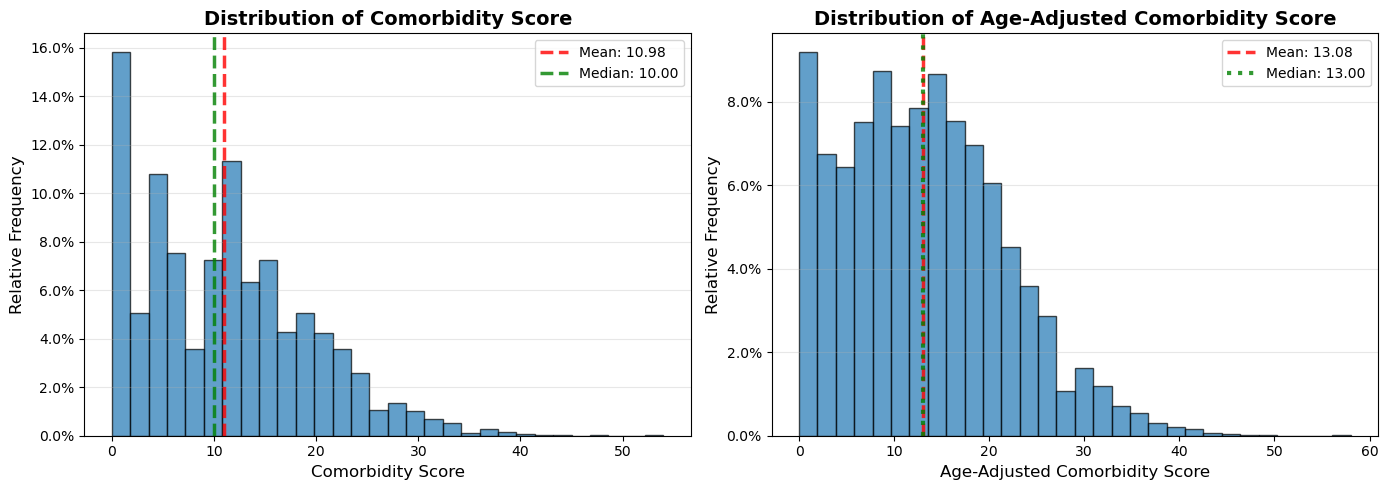

In [118]:
scores_to_plot = ['comorbidity_score']
if 'age_adj_comorbidity_score' in df.columns:
    scores_to_plot.append('age_adj_comorbidity_score')

# Create figure with subplots
n_plots = len(scores_to_plot)
fig, axes = plt.subplots(1, n_plots, figsize=(7*n_plots, 5))

# Handle single subplot case
if n_plots == 1:
    axes = [axes]

# Plot each score distribution
for idx, score_col in enumerate(scores_to_plot):
    ax = axes[idx]
    
    # Histogram with density=True for relative frequency
    weights = np.ones_like(df[score_col]) / len(df[score_col])
    ax.hist(df[score_col], bins=30, alpha=0.7, edgecolor='black', weights=weights)
    
    # Add mean and median lines
    mean_val = df[score_col].mean()
    median_val = df[score_col].median()
    
    # Plot mean first (behind)
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2.5, 
               label=f'Mean: {mean_val:.2f}', alpha=0.8)
    # Plot median with offset if too close
    if abs(mean_val - median_val) < 0.5:  # If very close, add slight offset
        ax.axvline(median_val, color='green', linestyle=':', linewidth=3, 
                   label=f'Median: {median_val:.2f}', alpha=0.8)
    else:
        ax.axvline(median_val, color='green', linestyle='--', linewidth=2.5, 
                   label=f'Median: {median_val:.2f}', alpha=0.8)
    
    # Labels and title
    title = 'Comorbidity Score' if score_col == 'comorbidity_score' else 'Age-Adjusted Comorbidity Score'
    ax.set_xlabel(title, fontsize=12)
    ax.set_ylabel('Relative Frequency', fontsize=12)
    ax.set_title(f'Distribution of {title}', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Format y-axis as percentage (optional)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))
    
    # Print values to verify
    print(f"{title}: Mean = {mean_val:.2f}, Median = {median_val:.2f}, Diff = {abs(mean_val - median_val):.2f}")

plt.tight_layout()
plt.show()

#### Remove discrepancies and export new df containing Elixhauser

In [121]:
elix = df.copy()

elix.head(3)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,SYSBP_MAX,SYSBP_COUNT,DIASBP_MEAN,DIASBP_MEDIAN,DIASBP_STD,DIASBP_MIN,DIASBP_MAX,DIASBP_COUNT,comorbidity_score,age_adj_comorbidity_score
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,162.0,98.0,52.326531,52.0,10.997446,12.0,86.0,98.0,20.0,22.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,126.0,65.0,51.538462,51.0,8.739417,32.0,78.0,65.0,4.0,4.0
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,163.0,79.0,48.594937,49.0,7.365058,33.0,71.0,79.0,15.0,19.0


In [123]:
# Load required tables
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('mimic-iii-clinical-database-1.4/ICUSTAYS.csv.gz') as gz_file:
        icustays = pd.read_csv(gz_file, compression='gzip')
    
    with zip_ref.open('mimic-iii-clinical-database-1.4/PATIENTS.csv.gz') as gz_file:
        patients = pd.read_csv(gz_file, compression='gzip')
    
    with zip_ref.open('mimic-iii-clinical-database-1.4/ADMISSIONS.csv.gz') as gz_file:
        admissions = pd.read_csv(gz_file, compression='gzip')

print(f"Starting with {len(icustays)} ICU stays")

# Convert date columns to datetime
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'])
patients['DOB'] = pd.to_datetime(patients['DOB'])
patients['DOD'] = pd.to_datetime(patients['DOD'])
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])
admissions['DEATHTIME'] = pd.to_datetime(admissions['DEATHTIME'])

# Merge to get patient DOB and DOD
df = icustays.merge(patients[['SUBJECT_ID', 'DOB', 'DOD']], on='SUBJECT_ID', how='left')

# Merge to get admission times, death time, AND HOSPITAL_EXPIRE_FLAG
df = df.merge(admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG']], 
              on=['SUBJECT_ID', 'HADM_ID'], how='left')

# Calculate age at ICU admission
df['age_years'] = df['INTIME'].dt.year - df['DOB'].dt.year
birthday_not_passed = (
    (df['INTIME'].dt.month < df['DOB'].dt.month) |
    ((df['INTIME'].dt.month == df['DOB'].dt.month) & (df['INTIME'].dt.day < df['DOB'].dt.day))
)
df.loc[birthday_not_passed, 'age_years'] -= 1
df.loc[df['age_years'] > 200, 'age_years'] = 90
df['AGE'] = df['age_years']

# Apply all exclusions
df = df[(df['FIRST_WARDID'] == df['LAST_WARDID']) & (df['FIRST_CAREUNIT'] == df['LAST_CAREUNIT'])]
print(f"After excluding ICU transfers: {len(df)}")

icu_stays_per_admission = df.groupby('HADM_ID').size()
single_icu_admissions = icu_stays_per_admission[icu_stays_per_admission == 1].index
df = df[df['HADM_ID'].isin(single_icu_admissions)]
print(f"After excluding multiple ICU stays per admission: {len(df)}")

df = df[df['AGE'] >= 18]
print(f"After excluding pediatric patients: {len(df)}")

df = df[df['LOS'].notna() & (df['LOS'] >= 2.0)]
print(f"After excluding LOS < 48 hours or unknown: {len(df)}")

# Calculate custom in-hospital mortality
mortality_dod = df['DOD'].notna() & (df['ADMITTIME'] <= df['DOD']) & (df['DOD'] <= df['DISCHTIME'])
mortality_deathtime = df['DEATHTIME'].notna() & (df['ADMITTIME'] <= df['DEATHTIME']) & (df['DEATHTIME'] <= df['DISCHTIME'])
df['MORTALITY_INHOSPITAL'] = (mortality_dod | mortality_deathtime).astype(int)

# ===== COMPARISON ANALYSIS =====
print("\n" + "="*70)
print("COMPARISON: MORTALITY_INHOSPITAL vs HOSPITAL_EXPIRE_FLAG")
print("="*70)

# Basic statistics
print(f"\nCustom MORTALITY_INHOSPITAL:")
print(f"  Deaths: {df['MORTALITY_INHOSPITAL'].sum()}")
print(f"  Rate: {df['MORTALITY_INHOSPITAL'].mean()*100:.2f}%")

print(f"\nMIMIC-III HOSPITAL_EXPIRE_FLAG:")
print(f"  Deaths: {df['HOSPITAL_EXPIRE_FLAG'].sum()}")
print(f"  Rate: {df['HOSPITAL_EXPIRE_FLAG'].mean()*100:.2f}%")

# Agreement analysis
agreement = (df['MORTALITY_INHOSPITAL'] == df['HOSPITAL_EXPIRE_FLAG']).sum()
disagreement = (df['MORTALITY_INHOSPITAL'] != df['HOSPITAL_EXPIRE_FLAG']).sum()

print(f"\n--- Agreement Analysis ---")
print(f"Cases where both agree: {agreement} ({agreement/len(df)*100:.2f}%)")
print(f"Cases where they differ: {disagreement} ({disagreement/len(df)*100:.2f}%)")

# Detailed breakdown of differences
if disagreement > 0:
    print(f"\n--- Breakdown of Differences ---")
    
    # Custom says dead, MIMIC says alive
    custom_dead_mimic_alive = (df['MORTALITY_INHOSPITAL'] == 1) & (df['HOSPITAL_EXPIRE_FLAG'] == 0)
    print(f"Custom=DEAD, MIMIC=ALIVE: {custom_dead_mimic_alive.sum()} cases")
    
    # Custom says alive, MIMIC says dead
    custom_alive_mimic_dead = (df['MORTALITY_INHOSPITAL'] == 0) & (df['HOSPITAL_EXPIRE_FLAG'] == 1)
    print(f"Custom=ALIVE, MIMIC=DEAD: {custom_alive_mimic_dead.sum()} cases")
    
    # Show examples of discrepancies
    print(f"\n--- Examples of Discrepancies ---")
    discrepancies = df[df['MORTALITY_INHOSPITAL'] != df['HOSPITAL_EXPIRE_FLAG']].copy()
    
    if len(discrepancies) > 0:
        
        # Cases where custom=1, MIMIC=0
        if custom_dead_mimic_alive.sum() > 0:
            subset = discrepancies[discrepancies['MORTALITY_INHOSPITAL'] == 1]
            print(f"\nCases marked as DEAD by custom but ALIVE by MIMIC ({len(subset)} cases):")
            print(f"  - Has DEATHTIME: {subset['DEATHTIME'].notna().sum()}")
            print(f"  - Has DOD: {subset['DOD'].notna().sum()}")
            print(f"  - Death within admission window: {((subset['ADMITTIME'] <= subset['DEATHTIME']) & (subset['DEATHTIME'] <= subset['DISCHTIME'])).sum()}")
        
        # Cases where custom=0, MIMIC=1
        if custom_alive_mimic_dead.sum() > 0:
            subset = discrepancies[discrepancies['HOSPITAL_EXPIRE_FLAG'] == 1]
            print(f"\nCases marked as ALIVE by custom but DEAD by MIMIC ({len(subset)} cases):")
            print(f"  - Has DEATHTIME: {subset['DEATHTIME'].notna().sum()}")
            print(f"  - Has DOD: {subset['DOD'].notna().sum()}")
            print(f"  - DEATHTIME is null: {subset['DEATHTIME'].isna().sum()}")
            print(f"  - DOD is null: {subset['DOD'].isna().sum()}")

# Confusion matrix
print(f"\n--- Confusion Matrix ---")
print(f"                          HOSPITAL_EXPIRE_FLAG")
print(f"                          Alive(0)  Dead(1)")
print(f"MORTALITY_     Alive(0)  {((df['MORTALITY_INHOSPITAL']==0) & (df['HOSPITAL_EXPIRE_FLAG']==0)).sum():7d}  {((df['MORTALITY_INHOSPITAL']==0) & (df['HOSPITAL_EXPIRE_FLAG']==1)).sum():7d}")
print(f"INHOSPITAL     Dead(1)   {((df['MORTALITY_INHOSPITAL']==1) & (df['HOSPITAL_EXPIRE_FLAG']==0)).sum():7d}  {((df['MORTALITY_INHOSPITAL']==1) & (df['HOSPITAL_EXPIRE_FLAG']==1)).sum():7d}")

print("\n" + "="*70)
print("CONCLUSION:")
if disagreement == 0:
    print("✓ The variables are IDENTICAL - no differences found!")
else:
    print(f"✗ The variables DIFFER in {disagreement} cases ({disagreement/len(df)*100:.2f}%)")
    print("  Review the discrepancies above to understand the differences.")
print("="*70)

# ===== REMOVE DISCREPANCIES =====
print("\n" + "="*70)
print("REMOVING DISCREPANCIES")
print("="*70)

len_before = len(df)
df = df[df['MORTALITY_INHOSPITAL'] == df['HOSPITAL_EXPIRE_FLAG']].copy()
len_after = len(df)

print(f"Rows before removal: {len_before}")
print(f"Rows after removal: {len_after}")
print(f"Rows removed: {len_before - len_after}")
print(f"Percentage removed: {(len_before - len_after)/len_before*100:.2f}%")

# Verify no discrepancies remain
remaining_discrepancies = (df['MORTALITY_INHOSPITAL'] != df['HOSPITAL_EXPIRE_FLAG']).sum()
print(f"\nVerification - Remaining discrepancies: {remaining_discrepancies}")

if remaining_discrepancies == 0:
    print("✓ All discrepancies successfully removed!")
else:
    print("✗ Warning: Some discrepancies still remain!")

print("="*70)

Starting with 61532 ICU stays
After excluding ICU transfers: 55830
After excluding multiple ICU stays per admission: 50186
After excluding pediatric patients: 42276
After excluding LOS < 48 hours or unknown: 21247

COMPARISON: MORTALITY_INHOSPITAL vs HOSPITAL_EXPIRE_FLAG

Custom MORTALITY_INHOSPITAL:
  Deaths: 2798
  Rate: 13.17%

MIMIC-III HOSPITAL_EXPIRE_FLAG:
  Deaths: 2775
  Rate: 13.06%

--- Agreement Analysis ---
Cases where both agree: 21178 (99.68%)
Cases where they differ: 69 (0.32%)

--- Breakdown of Differences ---
Custom=DEAD, MIMIC=ALIVE: 46 cases
Custom=ALIVE, MIMIC=DEAD: 23 cases

--- Examples of Discrepancies ---

Cases marked as DEAD by custom but ALIVE by MIMIC (46 cases):
  - Has DEATHTIME: 0
  - Has DOD: 46
  - Death within admission window: 0

Cases marked as ALIVE by custom but DEAD by MIMIC (23 cases):
  - Has DEATHTIME: 23
  - Has DOD: 23
  - DEATHTIME is null: 0
  - DOD is null: 0

--- Confusion Matrix ---
                          HOSPITAL_EXPIRE_FLAG
        

In [124]:
df.head(3)

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,...,LOS,DOB,DOD,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,age_years,AGE,MORTALITY_INHOSPITAL
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,...,3.2490,2132-02-21,2198-02-18,2198-02-11 13:40:00,2198-02-18 03:55:00,2198-02-18 03:55:00,1,65,65,1
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,...,3.2788,2130-09-30,NaT,2170-11-05 11:04:00,2170-11-27 18:00:00,NaT,0,40,40,0
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,...,2.8939,2048-05-26,NaT,2128-06-23 18:26:00,2128-06-27 12:31:00,NaT,0,80,80,0


In [125]:
elix = elix[elix['HADM_ID'].isin(df['HADM_ID'].unique())]

In [127]:
elix.shape

(21178, 45)

In [128]:
# elix.to_csv('hr_rr_t_ag_dbp_sbp_age_gender_mortality_elixhauser.csv', index = False)

In [129]:
y = pd.read_csv('hr_rr_t_ag_dbp_sbp_age_gender_mortality_elixhauser.csv')
y.head(4)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,SYSBP_MAX,SYSBP_COUNT,DIASBP_MEAN,DIASBP_MEDIAN,DIASBP_STD,DIASBP_MIN,DIASBP_MAX,DIASBP_COUNT,comorbidity_score,age_adj_comorbidity_score
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,162.0,98.0,52.326531,52.0,10.997446,12.0,86.0,98.0,20.0,22.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,126.0,65.0,51.538462,51.0,8.739417,32.0,78.0,65.0,4.0,4.0
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,163.0,79.0,48.594937,49.0,7.365058,33.0,71.0,79.0,15.0,19.0
3,274,130546,254851,0,92.716981,93.0,11.774120,63.0,116.0,53.0,...,197.0,241.0,69.780083,70.0,8.684599,44.0,109.0,241.0,0.0,2.0


In [130]:
y.shape

(21178, 45)

#### Create and export new df with the most promising features

In [138]:
features = pd.read_csv('hr_rr_t_ag_dbp_sbp_age_gender_mortality_elixhauser.csv')

In [139]:
features.head(5)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,SYSBP_MAX,SYSBP_COUNT,DIASBP_MEAN,DIASBP_MEDIAN,DIASBP_STD,DIASBP_MIN,DIASBP_MAX,DIASBP_COUNT,comorbidity_score,age_adj_comorbidity_score
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,162.0,98.0,52.326531,52.0,10.997446,12.0,86.0,98.0,20.0,22.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,126.0,65.0,51.538462,51.0,8.739417,32.0,78.0,65.0,4.0,4.0
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,163.0,79.0,48.594937,49.0,7.365058,33.0,71.0,79.0,15.0,19.0
3,274,130546,254851,0,92.716981,93.0,11.774120,63.0,116.0,53.0,...,197.0,241.0,69.780083,70.0,8.684599,44.0,109.0,241.0,0.0,2.0
4,275,129886,219649,1,59.933333,59.0,8.632391,49.0,90.0,45.0,...,180.0,193.0,79.331606,80.0,11.112769,50.0,102.0,193.0,9.0,13.0


Most promising features: AG_MEAN

AG_MAX

AG_MEDIAN

AG_MIN

AG_STD

SYSBP_MIN

SYSBP_MEAN

SYSBP_STD

DIASBP_MIN

DIASBP_MEAN

AGE

RR_MEAN

RR_STD

TEMP_STD

HR_MEAN

HR_STD

RR_MAX

TEMP_MIN

HR_MAX

HR_MEDIAN

comorbidity_score

age_adj_comorbidity_score

### Age analytics

In [131]:
df = pd.read_csv('hr_rr_t_ag_dbp_sbp_age_gender_mortality_elixhauser.csv')

In [132]:
# Path to your zip file
zip_path = r"C:\Users\maxim\Downloads\mimic-iii-clinical-database-1.4.zip"

# Load required tables
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('mimic-iii-clinical-database-1.4/ICUSTAYS.csv.gz') as gz_file:
        icustays = pd.read_csv(gz_file, compression='gzip')
    
    with zip_ref.open('mimic-iii-clinical-database-1.4/PATIENTS.csv.gz') as gz_file:
        patients = pd.read_csv(gz_file, compression='gzip')
    
    with zip_ref.open('mimic-iii-clinical-database-1.4/ADMISSIONS.csv.gz') as gz_file:
        admissions = pd.read_csv(gz_file, compression='gzip')


# Convert date columns to datetime
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'])
patients['DOB'] = pd.to_datetime(patients['DOB'])
patients['DOD'] = pd.to_datetime(patients['DOD'])
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])
admissions['DEATHTIME'] = pd.to_datetime(admissions['DEATHTIME'])

# Merge to get patient DOB and DOD
df = icustays.merge(patients[['SUBJECT_ID', 'DOB', 'DOD']], on='SUBJECT_ID', how='left')

# Merge to get admission times, death time, AND HOSPITAL_EXPIRE_FLAG
df = df.merge(admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG']], 
              on=['SUBJECT_ID', 'HADM_ID'], how='left')

# Calculate age at ICU admission
df['age_years'] = df['INTIME'].dt.year - df['DOB'].dt.year

In [133]:
df['age_years'].head()

0    66
1    40
2    80
3    46
4    67
Name: age_years, dtype: int32

In [134]:
x = df[df['age_years'] > 299]

In [135]:
x[['SUBJECT_ID', 'HADM_ID', 'age_years']].head(10)

,SUBJECT_ID,HADM_ID,age_years
40,304,177469,300
91,345,169339,300
200,112,174105,300
201,112,173177,302
247,149,154869,300
249,151,151029,300
268,166,128219,300
277,175,159223,300
278,175,176764,301
331,213,179315,300


In [136]:
x['HADM_ID'].nunique()

2581

In [137]:
df['HADM_ID'].nunique()

57786